In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,GRU
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from utils.data_split import split_sequence_parallel

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\InfoGainTiantandata.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [3]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
scaler9 = MinMaxScaler(feature_range=(0, 1))
scaler10 = MinMaxScaler(feature_range=(0, 1))
scaler11 = MinMaxScaler(feature_range=(0, 1))
scaler12 = MinMaxScaler(feature_range=(0, 1))
scaler13 = MinMaxScaler(feature_range=(0, 1))
scaler14 = MinMaxScaler(feature_range=(0, 1))
scaler15 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['PM2.5']=scaler1.fit_transform(data_minmax['PM2.5'].values.reshape(-1,1))
data_minmax['PM10']=scaler2.fit_transform(data_minmax['PM10'].values.reshape(-1,1))
data_minmax['SO2']=scaler3.fit_transform(data_minmax['SO2'].values.reshape(-1,1))
data_minmax['NO2']=scaler4.fit_transform(data_minmax['NO2'].values.reshape(-1,1))
data_minmax['CO']=scaler5.fit_transform(data_minmax['CO'].values.reshape(-1,1))
data_minmax['O3']=scaler6.fit_transform(data_minmax['O3'].values.reshape(-1,1))
data_minmax['TEMP']=scaler7.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler8.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['DEWP']=scaler9.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['wd_E']=scaler10.fit_transform(data_minmax['wd_E'].values.reshape(-1,1))
data_minmax['wd_ENE']=scaler11.fit_transform(data_minmax['wd_ENE'].values.reshape(-1,1))
data_minmax['wd_ESE']=scaler12.fit_transform(data_minmax['wd_ESE'].values.reshape(-1,1))
data_minmax['wd_NE']=scaler13.fit_transform(data_minmax['wd_NE'].values.reshape(-1,1))
data_minmax['wd_NW']=scaler14.fit_transform(data_minmax['wd_NW'].values.reshape(-1,1))
data_minmax['wd_SW']=scaler15.fit_transform(data_minmax['wd_SW'].values.reshape(-1,1))

In [4]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = -10200
cast2 = -2880
cast3 = -1416                                                                      
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:cast3] 
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [5]:
data_test = np.array(data_test)
data_train = np.array(data_train)
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [6]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [7]:
X.shape,y.shape,data_test.shape

((7288, 21, 15), (7288, 12), (1464, 15))

In [8]:
def GRU_model():
    ip = Input(shape=(sw_width,features))
    
    x = GRU(100,activation="relu")(ip)
#     x = Dense(32,activation="relu")(x)
    x = Dropout(0.8)(x)
#     x = BatchNormalizati100()(x)

    out = Dense(pred_length)(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [9]:
GRU_model1=GRU_model()
GRU_model1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 15)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               34800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 36,012
Trainable params: 36,012
Non-trainable params: 0
_________________________________________________________________


In [10]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\GRU_model_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]
starttime=time.time()
GRU_model1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = GRU_model1.fit(X,y,validation_split=0.33,epochs=100, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 4882 samples, validate on 2406 samples
Epoch 1/100
 - 5s - loss: 0.0885 - val_loss: 0.0525

Epoch 00001: val_loss improved from inf to 0.05249, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\GRU_model_weights_best.hdf5
Epoch 2/100
 - 5s - loss: 0.0664 - val_loss: 0.0475

Epoch 00002: val_loss improved from 0.05249 to 0.04746, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\GRU_model_weights_best.hdf5
Epoch 3/100
 - 5s - loss: 0.0633 - val_loss: 0.0455

Epoch 00003: val_loss improved from 0.04746 to 0.04545, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\GRU_model_weights_best.hdf5
Epoch 4/100
 - 5s - loss: 0.0621 - val_loss: 0.0423

Epoch 00004: val_loss improved from 0.04545 to 0.04228, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\GRU_model_weights_best.hdf5
Epoch 5/100
 - 5s - loss: 0.0613 - val_loss: 0.0415

Epoch 00005: val_loss improved from 0.04228 to 0.04151, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天

 - 5s - loss: 0.0500 - val_loss: 0.0404

Epoch 00067: val_loss did not improve from 0.03818
Epoch 68/100
 - 5s - loss: 0.0503 - val_loss: 0.0400

Epoch 00068: val_loss did not improve from 0.03818
Epoch 69/100
 - 5s - loss: 0.0523 - val_loss: 0.0423

Epoch 00069: val_loss did not improve from 0.03818
Epoch 70/100
 - 5s - loss: 0.0518 - val_loss: 0.0420

Epoch 00070: val_loss did not improve from 0.03818
Epoch 71/100
 - 5s - loss: 0.0515 - val_loss: 0.0414

Epoch 00071: val_loss did not improve from 0.03818
Epoch 72/100
 - 6s - loss: 0.0506 - val_loss: 0.0405

Epoch 00072: val_loss did not improve from 0.03818
Epoch 73/100
 - 5s - loss: 0.0520 - val_loss: 0.0406

Epoch 00073: val_loss did not improve from 0.03818
Epoch 74/100
 - 5s - loss: 0.0501 - val_loss: 0.0420

Epoch 00074: val_loss did not improve from 0.03818
Epoch 75/100
 - 5s - loss: 0.0502 - val_loss: 0.0418

Epoch 00075: val_loss did not improve from 0.03818
Epoch 76/100
 - 5s - loss: 0.0508 - val_loss: 0.0409

Epoch 00076: v

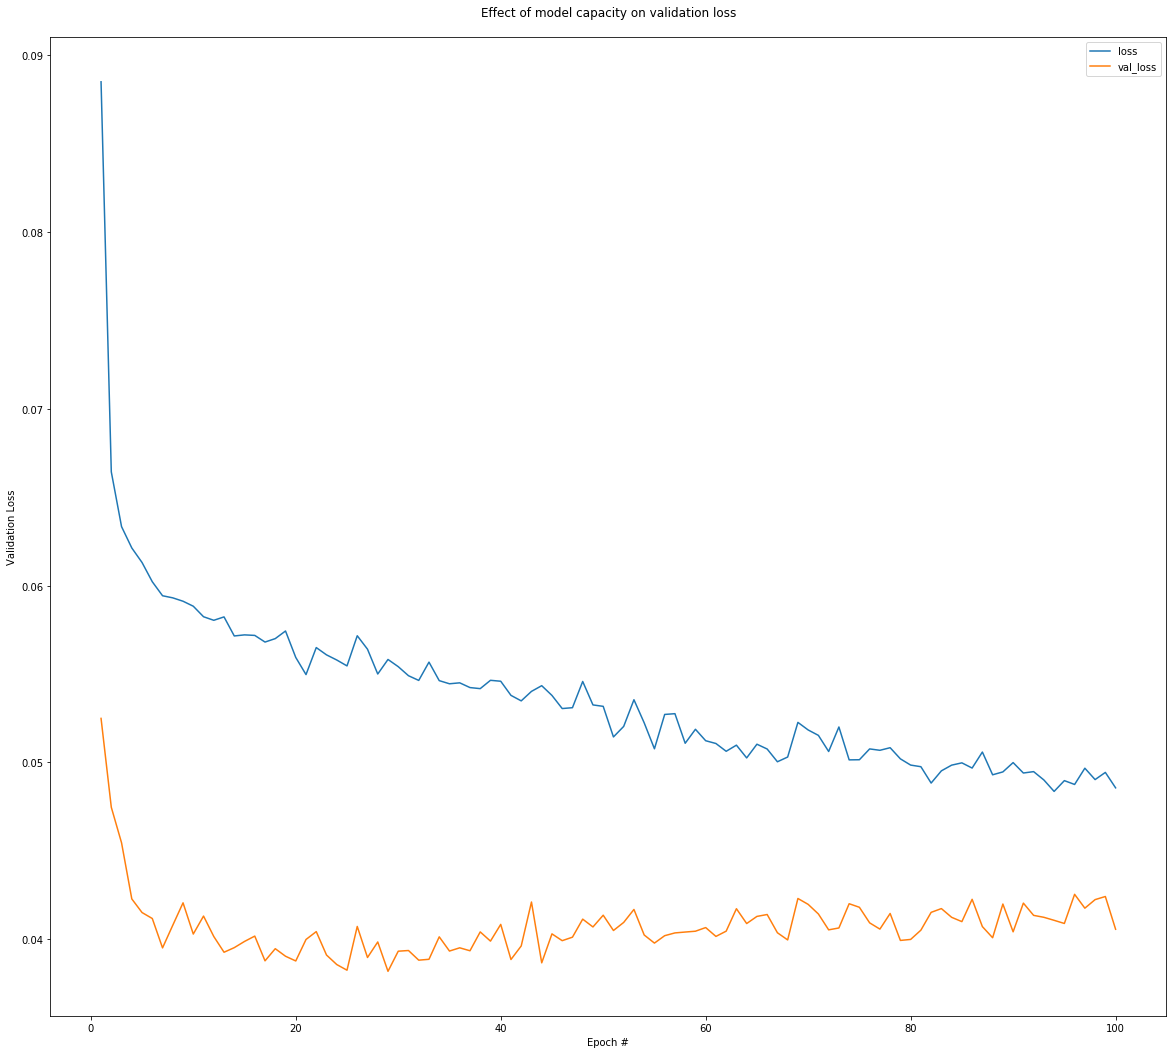

In [11]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(100) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [10]:
filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\GRU_model_weights_best.hdf5"
GRU_model1.load_weights(filepath)

In [11]:
predict=GRU_model1.predict(test_x)
predict=scaler1.inverse_transform(predict)

In [12]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

63.512335495013176

In [13]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y)).numpy().mean()

57.285017841625645

In [14]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 50.08977723848894
1 : 59.56293791802594
2 : 67.90295572724644
3 : 74.52853576010696
4 : 80.66195388313902
5 : 85.54007751232784
6 : 89.1594820102579


In [15]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 5.741143984244632
1 : 6.251141685829255
2 : 6.696206066782954
3 : 7.067507689634662
4 : 7.3915069121970385
5 : 7.650452154815166
6 : 7.866851175433634


In [16]:
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6])).numpy().mean())
print(tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6]).numpy().mean())
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:])).numpy().mean())
print(tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:]).numpy().mean())

50.36351543981853
46.66502331036319
71.10088012818612
67.90501237288812
